### 1. 분류모델 평가 심화 실습 (ROC / Threshold / PR Curve)

- 확률 기반 분류 모델의 성능을 곡선으로 해석
- Threshold를 바꾸면 무엇이 어떻게 달라지는지 이해
- 불균형 데이터에서 왜 PR 곡선이 중요한지 이해

In [1]:
# 준비 (데이터 & 모델)
# 앞에서 사용한 데이터와 동일한 맥락
# 연체 = 1 (양성 클래스)

#### 라이브러리 로드

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve,
    confusion_matrix
)

from matplotlib import rc
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False


#### 데이터 준비

In [5]:
df = pd.DataFrame({
    "customer":  [f"고객{i}" for i in range(1, 13)],
    "sales":     [100,120,130,140,150,200,220,180,190,200,210,120],
    "income":    [10,12,13,14,15,16,17,20,22,19,20,22],
    "interest":  [1.2,1.5,1.4,1.3,1.4,1.5,1.4,1.4,1.4,1.5,1.5,1.5],
    "loans":     [100,105,102,103,104,104,105,105,103,102,104,105],
    "status":    ["정상","정상","연체","정상","정상","정상",
                  "정상","정상","정상","정상","연체","연체"]
})

# 타깃 인코딩: 정상=0, 연체=1
df["y"] = df["status"].map({"정상":0, "연체":1})

X = df[["sales","income","interest","loans"]]
y = df["y"]


#### Train / Test 분할 + 스케일링

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


#### 로지스틱 회귀 → 연체 예측 확률 (테스트 데이터)

In [8]:
model = LogisticRegression()
model.fit(X_train_sc, y_train)

# 연체(1)일 확률
y_prob = model.predict_proba(X_test_sc)[:, 1]

# 확률 결과 확인
result_df = X_test.copy()
result_df["실제값(y)"] = y_test.values
result_df["연체_예측확률"] = y_prob
result_df.round(3)


,sales,income,interest,loans,실제값(y),연체_예측확률
11,120,22,1.5,105,1,0.295
7,180,20,1.4,105,0,0.209
4,150,15,1.4,104,0,0.223
5,200,16,1.5,104,0,0.318


#### 모든 고객(1~12) 부도확률 계산 

In [9]:
# 전체 고객 데이터 (설명변수)
X_all = df[["sales", "income", "interest", "loans"]]

# ⚠️ Train 데이터로 fit된 scaler 사용
X_all_sc = scaler.transform(X_all)

# 부도(연체=1) 확률 예측
all_prob = model.predict_proba(X_all_sc)[:, 1]

# 결과 표로 정리
all_result_df = df[["customer", "status"]].copy()
all_result_df["부도_예측확률"] = all_prob

# 보기 좋게 소수점 정리
all_result_df = all_result_df.round(3)

all_result_df


,customer,status,부도_예측확률
0,고객1,정상,0.142
1,고객2,정상,0.289
2,고객3,연체,0.259
3,고객4,정상,0.165
4,고객5,정상,0.223
5,고객6,정상,0.318
6,고객7,정상,0.209
7,고객8,정상,0.209
8,고객9,정상,0.247
9,고객10,정상,0.367


### 2. ROC Curve / AUC 시각화 

- ROC Curve는 분류 모델의 성능을 모든 기준값에서 평가하는 그래프이고,
- AUC는 그 그래프 아래 면적이다.
- ROC Curve란? : 분류기준값(Threshold)를 바꿔가며 TPR(Recall) vs FPR을 그린 곡선
- x축: FPR (False Positive Rate)
- y축: TPR (True Positive Rate = Recall)

- AUC란? ROC Curve 아래 면적
- AUC 값	의미
- 0.5	랜덤
- 0.7 ~ 0.8	보통
- 0.8 ~ 0.9	좋음
- 1.0	완벽
- 확률적으로 양성을 음성보다 높게 점수 줄 확률

In [ ]:
# 대각선 = 랜덤 분류

# 곡선이 왼쪽 위로 갈수록 좋음

# AUC = 0.5 → 랜덤, 1.0 → 완벽

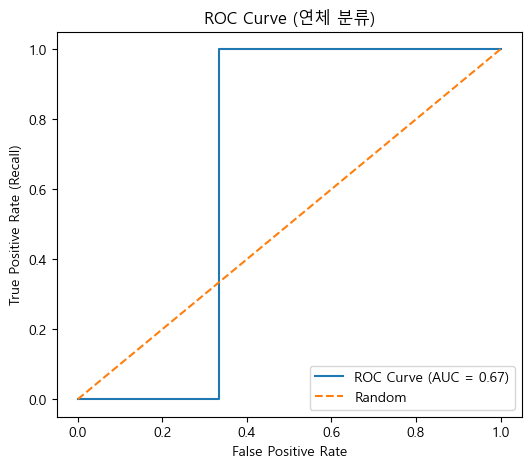

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (연체 분류)")
plt.legend()
plt.show()


### 3. Threshold 변화 실습

In [14]:
def threshold_eval(threshold):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp / (tp + fp) if (tp+fp)>0 else 0
    recall    = tp / (tp + fn) if (tp+fn)>0 else 0
    return precision, recall

thresholds_test = [0.3, 0.5, 0.7]

for th in thresholds_test:
    p, r = threshold_eval(th)
    print(f"Threshold={th:.1f} → Precision={p:.2f}, Recall={r:.2f}")


Threshold=0.3 → Precision=0.00, Recall=0.00
Threshold=0.5 → Precision=0.00, Recall=0.00
Threshold=0.7 → Precision=0.00, Recall=0.00


In [ ]:
# 왜 ROC 말고 PR Curve를 보나?
# 데이터가 불균형할 때
# 연체 탐지”처럼 양성 클래스가 중요할 때

### 4. Precision–Recall Curve : PR Curve = 정밀도 ↔ 재현율의 균형

In [ ]:
- Precision–Recall Curve는 분류 모델의 임계값(threshold)에 따라 정밀도와 재현율의 trade-off를 보여주는 그래프이다.    

- x축: Recall
- y축: Precision
- 점 하나 = 특정 분류 기준값(threshold)
- 기준값을 바꾸면 Precision과 Recall이 서로 반대로 변함

- 데이터 불균형(class imbalance) 문제에서 매우 유용
- 양성클래스가 중요한 문제
- 질병 진단
- 사기 탐지
- 연체 예측

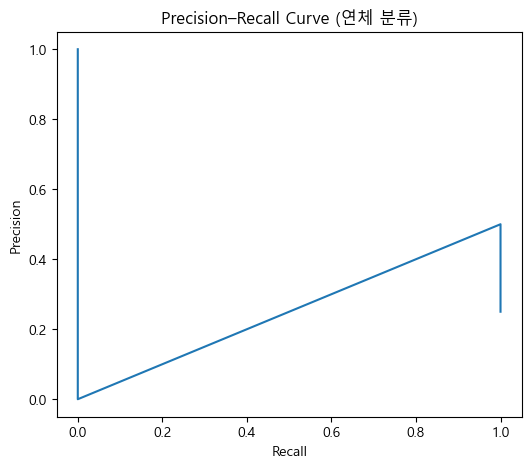

In [15]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (연체 분류)")
plt.show()
